In [1]:
import pydicom
import numpy
import numpy as np
import cv2
import os
import math
import pylab
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from scipy import ndimage
from skimage import morphology

In [2]:
import pydicom
file_path = "ID_000270f8b.dcm"
medical_image = pydicom.read_file(file_path)
print(medical_image)

Dataset.file_meta -------------------------------
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 10000000208461
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'RSNA Challenge 2019'
-------------------------------------------------
(0008, 0018) SOP Instance UID                    UI: ID_000270f8b
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_4942f4e0'
(0020, 000d) Study Instance UID                  UI: ID_7b6962cbb9
(0020, 000e) Series Instance UID                 UI: ID_597a2eb6cf
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: [-125, -88, 292.300049]
(0020, 0037) Image Orientation (Patient)         DS: [1, 0, 0, 0, 1, 0]
(0028, 0002) Samp

C:\Users\Swasti\anaconda3\lib\site-packages\pydicom\valuerep.py:443: UserWarning: The value length (20) exceeds the maximum length of 16 allowed for VR SH.
  warnings.warn(msg)
C:\Users\Swasti\anaconda3\lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: 'ID_000270f8b'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
C:\Users\Swasti\anaconda3\lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: 'ID_7b6962cbb9'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)
C:\Users\Swasti\anaconda3\lib\site-packages\pydicom\valuerep.py:443: UserWarning: Invalid value for VR UI: 'ID_597a2eb6cf'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


In [3]:
image = medical_image.pixel_array
print(image.shape)

(512, 512)


In [4]:
print(image.min())
print(image.max())

5
2365


In [5]:
import numpy as np
normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image))
print(normalized_image)


[[0.00847458 0.00762712 0.00762712 ... 0.00932203 0.00932203 0.00974576]
 [0.00889831 0.00762712 0.00762712 ... 0.00932203 0.00974576 0.01016949]
 [0.00932203 0.00847458 0.00805085 ... 0.00889831 0.00932203 0.00974576]
 ...
 [0.01483051 0.01525424 0.01483051 ... 0.01355932 0.01398305 0.01440678]
 [0.01483051 0.01483051 0.01483051 ... 0.01313559 0.01313559 0.01313559]
 [0.01525424 0.01483051 0.01398305 ... 0.01271186 0.01271186 0.01271186]]


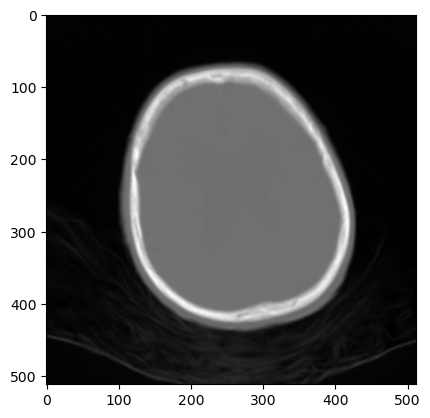

In [6]:
import matplotlib.pyplot as plt
# plt.imshow(image,cmap='jet')
plt.imshow(image,cmap='gray')

In [7]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = image * slope + intercept

    return hu_image

In [8]:
def window_image(image, window_center, window_width):
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    window_image = image.copy()
    window_image[window_image < img_min] = img_min
    window_image[window_image > img_max] = img_max
    
    return window_image

In [9]:
def remove_noise(file_path, display=False):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    
    hu_image = transform_to_hu(medical_image, image)
    brain_image = window_image(hu_image, 40, 80)
    
    segmentation = morphology.dilation(brain_image, np.ones((1, 1)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int32))
    label_count[0] = 0

    mask = labels == label_count.argmax()
    
    # Improve the brain mask
    mask = morphology.dilation(mask, np.ones((1, 1)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    masked_image = mask * brain_image

    if display:
        plt.figure(figsize=(15, 2.5))
        plt.subplot(141)
        plt.imshow(brain_image)
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(142)
        plt.imshow(mask)
        plt.title('Mask')
        plt.axis('off')

        plt.subplot(143)
        plt.imshow(masked_image)
        plt.title('Final Image')
        plt.axis('off')
    
    return masked_image

C:\Users\Swasti\AppData\Local\Temp\ipykernel_10248\686773013.py:18: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  mask = ndimage.morphology.binary_fill_holes(mask)


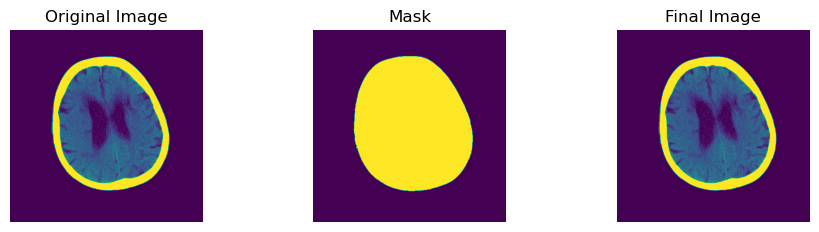

In [10]:
_ = remove_noise(file_path, display=True)

In [11]:
path2 = "ID_000000e27.dcm"

C:\Users\Swasti\AppData\Local\Temp\ipykernel_10248\686773013.py:18: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  mask = ndimage.morphology.binary_fill_holes(mask)


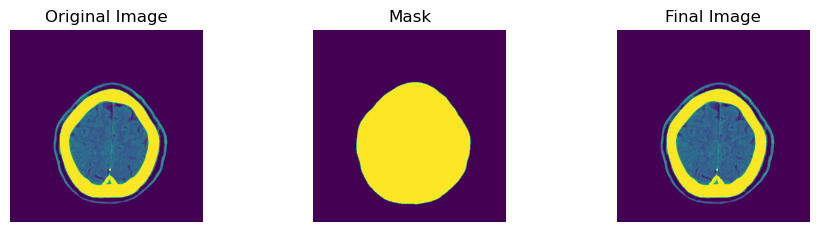

In [12]:
iskemiMaskedImg = remove_noise(path2, display=True)

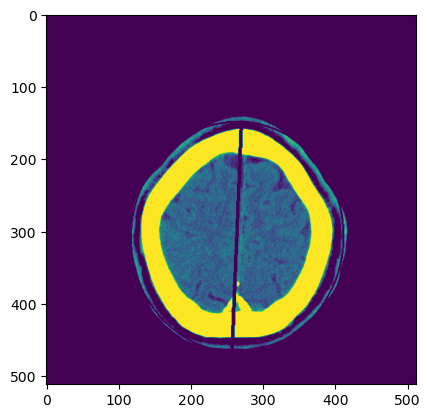

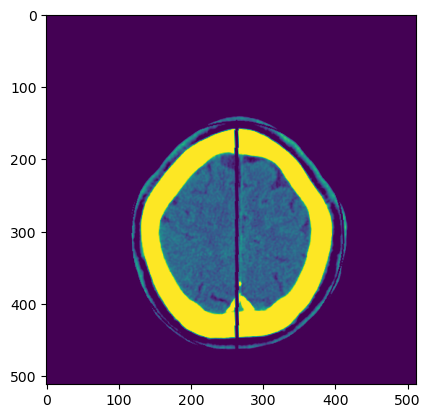

In [13]:
img=numpy.uint8 (iskemiMaskedImg)
contours, hier =cv2.findContours (img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask=numpy.zeros (img.shape, numpy.uint8)

c = max(contours, key = cv2.contourArea)

(x,y),(MA,ma),angle = cv2.fitEllipse(c)

cv2.ellipse(img, ((x,y), (MA,ma), angle), color=(0, 255, 0), thickness=2)

rmajor = max(MA,ma)/2
if angle > 90:
    angle -= 90
else:
    angle += 90
xtop = x + math.cos(math.radians(angle))*rmajor
ytop = y + math.sin(math.radians(angle))*rmajor
xbot = x + math.cos(math.radians(angle+180))*rmajor
ybot = y + math.sin(math.radians(angle+180))*rmajor
cv2.line(img, (int(xtop),int(ytop)), (int(xbot),int(ybot)), (0, 255, 0), 3)

pylab.imshow(img)
pylab.show()

M = cv2.getRotationMatrix2D((x, y), angle-90, 1)  #transformation matrix

img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), cv2.INTER_CUBIC)

pylab.imshow(img)
pylab.show()

In [14]:
def crop_image(image, display=False):
    # Create a mask with the background pixels
    mask = image == 0

    # Find the brain area
    coords = np.array(np.nonzero(~mask))
    top_left = np.min(coords, axis=1)
    bottom_right = np.max(coords, axis=1)
    
    # Remove the background
    croped_image = image[top_left[0]:bottom_right[0],
                top_left[1]:bottom_right[1]]
    
    return croped_image

In [15]:
croppedImage = crop_image(img)

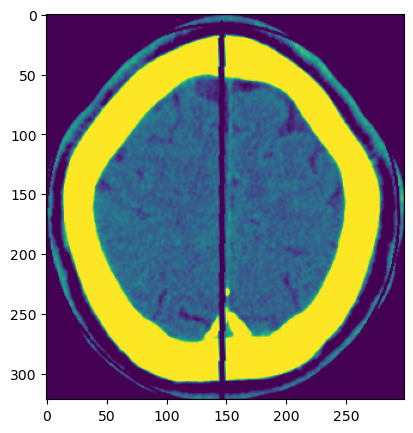

In [16]:
plt.figure(figsize=(15, 5))
plt.imshow(croppedImage)

In [17]:
def add_pad(image, new_height=512, new_width=512):
    height, width = image.shape

    final_image = np.zeros((new_height, new_width))

    pad_left = int((new_width - width) // 2)
    pad_top = int((new_height - height) // 2)
    
    
    # Replace the pixels with the image's pixels
    final_image[pad_top:pad_top + height, pad_left:pad_left + width] = image
    
    return final_image

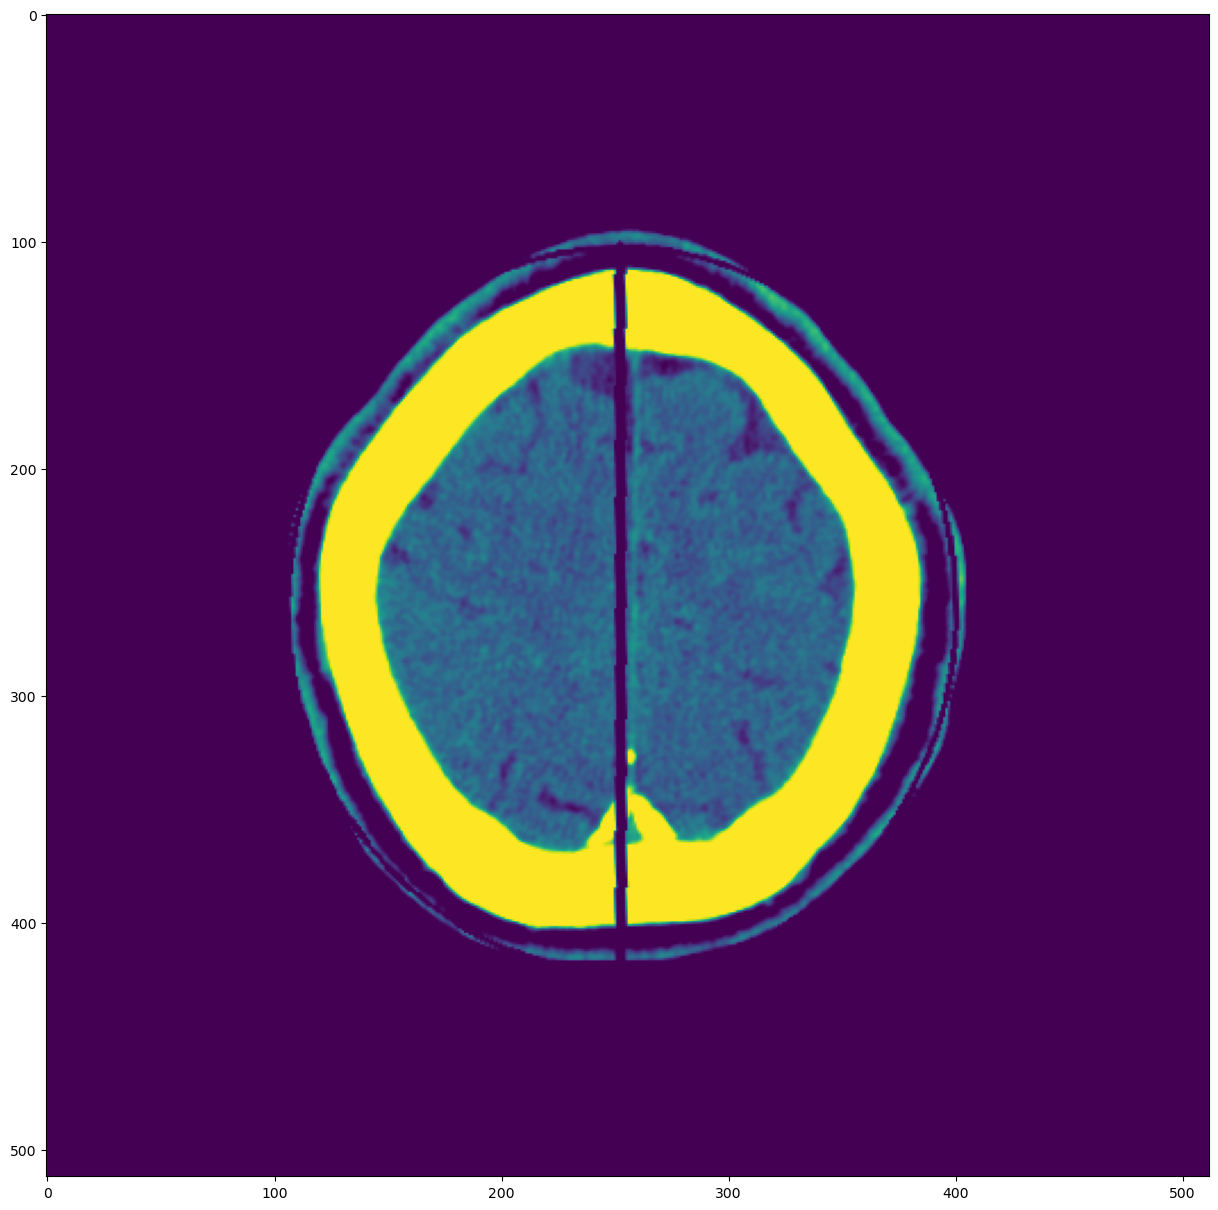

In [18]:
plt.figure(figsize=(15, 25))
final_image = add_pad(croppedImage)
plt.imshow(final_image)

In [23]:
new_name = "new_MR_3.png"
folder_name = "C:/Users/Swasti/OneDrive/Desktop/ds"
cv2.imwrite(os.path.join(folder_name,new_name),final_image*3)

True

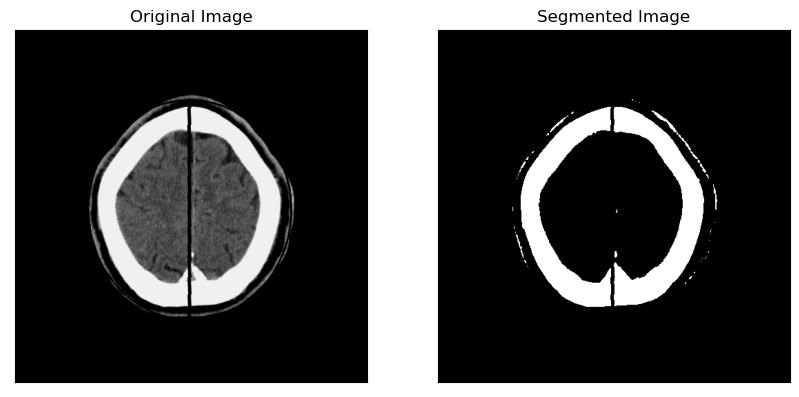

In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image from the same directory
image = cv2.imread('new_MR_3.png')  # Replace 'your_image.jpg' with the actual image file name

# Check if the image was loaded successfully
if image is None:
    print("Error: Image not found or could not be loaded.")
else:
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply a threshold to segment the image
    _, segmented_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

    # Display the original and segmented images
    plt.figure(figsize=(10, 5))
    plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), cmap='gray')
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(122), plt.imshow(segmented_image, cmap='gray')
    plt.title('Segmented Image'), plt.xticks([]), plt.yticks([])

    plt.show()


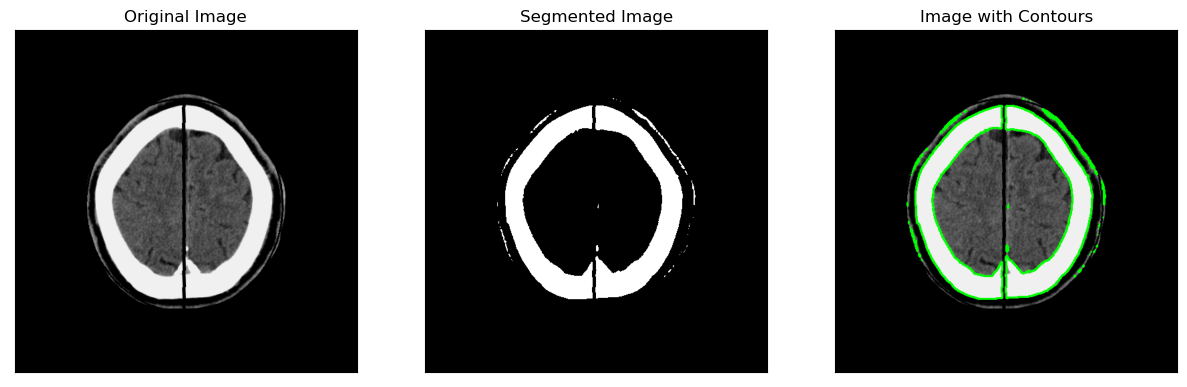

In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('new_MR_3.png')  # Replace 'your_image.jpg' with the actual image file name

# Check if the image was loaded successfully
if image is None:
    print("Error: Image not found or could not be loaded.")
else:
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to segment the image
    _, segmented_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

    # Find contours in the segmented image
    contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on a copy of the original image
    image_with_contours = image.copy()
    cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)

    # Display the original image, segmented image, and image with contours
    plt.figure(figsize=(15, 5))

    plt.subplot(131), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(132), plt.imshow(segmented_image, cmap='gray')
    plt.title('Segmented Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(133), plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    plt.title('Image with Contours'), plt.xticks([]), plt.yticks([])

    plt.show()


Contour 1: Area = 1.0, Perimeter = 4.828427076339722, Centroid = (358, 368)
Contour 2: Area = 6.0, Perimeter = 12.485281109809875, Centroid = (365, 360)
Contour 3: Area = 1.0, Perimeter = 4.828427076339722, Centroid = (371, 353)
Contour 4: Area = 0.0, Perimeter = 0.0, Centroid = (0, 0)
Contour 5: Area = 0.0, Perimeter = 0.0, Centroid = (0, 0)
Contour 6: Area = 0.0, Perimeter = 0.0, Centroid = (0, 0)
Contour 7: Area = 3.5, Perimeter = 10.242640614509583, Centroid = (126, 336)
Contour 8: Area = 0.0, Perimeter = 0.0, Centroid = (0, 0)
Contour 9: Area = 0.0, Perimeter = 2.8284270763397217, Centroid = (0, 0)
Contour 10: Area = 0.0, Perimeter = 0.0, Centroid = (0, 0)
Contour 11: Area = 0.0, Perimeter = 4.828427076339722, Centroid = (0, 0)
Contour 12: Area = 21.5, Perimeter = 21.071067690849304, Centroid = (257, 326)
Contour 13: Area = 0.0, Perimeter = 0.0, Centroid = (0, 0)
Contour 14: Area = 35.0, Perimeter = 76.28427076339722, Centroid = (118, 313)
Contour 15: Area = 0.0, Perimeter = 0.0, 

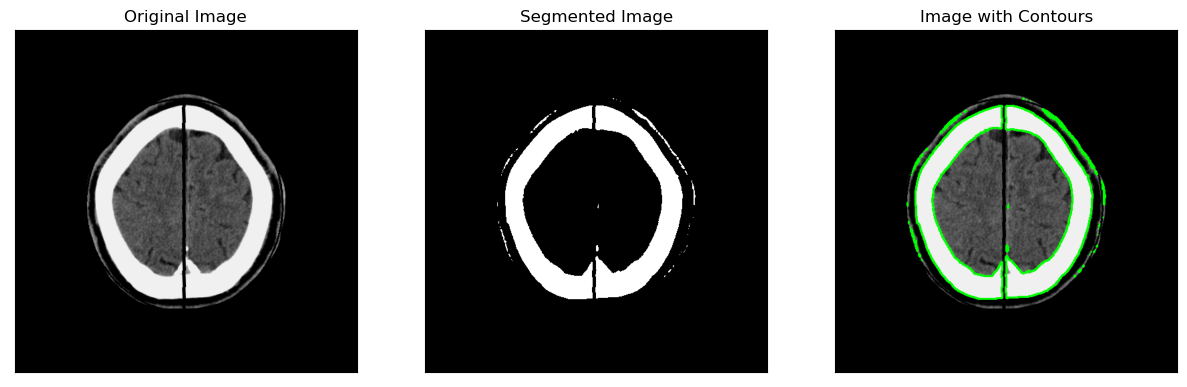

In [28]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('new_MR_3.png')  # Replace 'your_image.jpg' with the actual image file name

# Check if the image was loaded successfully
if image is None:
    print("Error: Image not found or could not be loaded.")
else:
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to segment the image
    _, segmented_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

    # Find contours in the segmented image
    contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the contours on a copy of the original image
    image_with_contours = image.copy()
    cv2.drawContours(image_with_contours, contours, -1, (0, 255, 0), 2)

    # Process the detected contours
    for i, contour in enumerate(contours):
        # Calculate the area of each contour
        area = cv2.contourArea(contour)

        # Calculate the perimeter (arc length) of each contour
        perimeter = cv2.arcLength(contour, True)

        # Calculate the coordinates of the centroid of each contour
        M = cv2.moments(contour)
        if M["m00"] != 0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
        else:
            cx, cy = 0, 0

        # Display information about each contour
        print(f"Contour {i + 1}: Area = {area}, Perimeter = {perimeter}, Centroid = ({cx}, {cy})")

    # Display the original image, segmented image, and image with contours
    plt.figure(figsize=(15, 5))

    plt.subplot(131), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(132), plt.imshow(segmented_image, cmap='gray')
    plt.title('Segmented Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(133), plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
    plt.title('Image with Contours'), plt.xticks([]), plt.yticks([])

    plt.show()


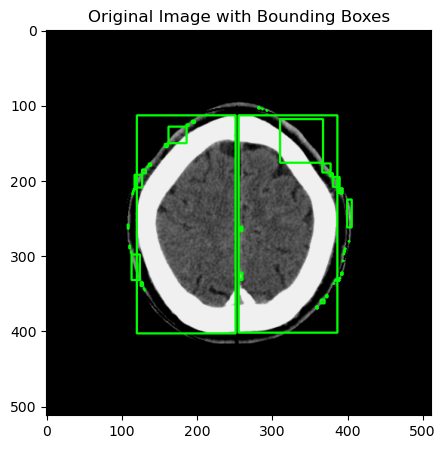

In [21]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
image = cv2.imread('new_MR_3.png')  # Replace 'your_image.jpg' with the actual image file name

# Check if the image was loaded successfully
if image is None:
    print("Error: Image not found or could not be loaded.")
else:
    # Convert the image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply thresholding to segment the image
    _, segmented_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)

    # Find connected components and calculate statistics
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(segmented_image, connectivity=8)

    # Draw bounding boxes around objects
    for i in range(1, num_labels):
        x, y, w, h, area = stats[i]
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Display the original image with bounding boxes
    plt.figure(figsize=(10, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original Image with Bounding Boxes')
    plt.show()
